In [124]:
import dare
import random
import time
import numpy as np
import pandas as pd
import copy
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from SISA_lib2 import SISA

In [125]:
data = pd.read_csv("cleaned_loan.csv")

In [126]:
labelEncoder = {}
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    labelEncoder[col] = le

In [127]:
data = data.drop_duplicates()

In [128]:
X = data.drop(["Keputusan Akhir"], axis=1)
y = data["Keputusan Akhir"]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
X_train_base = X_train.copy()
y_train_base = y_train.copy()
X_test_base = X_test.copy()

In [131]:
X_train_base_exp1 = X_train.copy()
y_train_base_exp1 = y_train.copy()
X_test_base_exp1 = X_test.copy()

In [132]:
#SISA train and test dataset formats
X_train_SISA = X_train.values
y_train_SISA = y_train.values
X_test_SISA = X_test.values

In [133]:
#SISA train and test dataset formats for exp 1
X_train_SISA_exp1 = X_train.values
y_train_SISA_exp1 = y_train.values
X_test_SISA_exp1 = X_test.values

In [134]:
#DaRE Forest train dataset
X_train_dare = np.array(X_train.values.tolist())
y_train_dare = np.array(y_train.values.tolist())
X_test_dare = np.array(X_test.values.tolist())

In [135]:
#DaRE Forest train dataset for exp 1
X_train_dare_exp1 = np.array(X_train.values.tolist())
y_train_dare_exp1 = np.array(y_train.values.tolist())
X_test_dare_exp1 = np.array(X_test.values.tolist()) 
X_train_dare_exp2 = np.array(X_train.values.tolist())
y_train_dare_exp2 = np.array(y_train.values.tolist())
X_test_dare_exp2 = np.array(X_test.values.tolist()) 

In [136]:
#make model for each machine learning model

In [137]:
#Base Model
base_model = RandomForestClassifier(random_state=42)

In [138]:
#Using grid test to get best hyperparameters tuning

In [139]:
grid_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 2, 3, 4, 5]
}

In [140]:
grid_search_base_model = GridSearchCV(
    estimator=base_model,
    param_grid=grid_params,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

In [141]:
grid_search_base_model.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy', verbose=2)

In [142]:
print("Parameter terbaik:", grid_search_base_model.best_params_)

Parameter terbaik: {'max_depth': 5, 'n_estimators': 100}


In [143]:
#Base Model using RandomForest
tree_model = grid_search_base_model.best_estimator_
tree_model.fit(X_train_base, y_train_base)

RandomForestClassifier(max_depth=5, random_state=42)

In [144]:
#predict using XGBoost model
y_pred_tree = tree_model.predict(X_test_base)
accuracy_tree = accuracy_score(y_pred_tree, y_test)
print(f"Akurasi Model Random Forest : {accuracy_tree}")

Akurasi Model Random Forest : 0.9444444444444444


In [145]:
#SISA Model akurasi by shard
shard = 2
accuracy = 1
exp_results = pd.DataFrame(columns=['Shard', 'Accuracy'])

In [146]:
while accuracy > 0.90:
    sisa_by_shard = SISA(shard, tree_model)
    sisa_by_shard .fit(X_train_SISA, y_train_SISA)
    y_pred = sisa_by_shard .predict(X_test_SISA)
    accuracy = accuracy_score(y_pred, y_test)
    exp_results = pd.concat([exp_results, pd.DataFrame([{'Shard': shard, 'Accuracy': accuracy}])], ignore_index=True)
    shard += 1

In [147]:
#show sisa accuracy by shard
data_result = pd.DataFrame(exp_results)
data_result

,Shard,Accuracy
0,2,0.916667
1,3,0.944444
2,4,0.888889


In [148]:
#Base on result below, SISA model will use 4 shard for expriment
sisa = SISA(3, tree_model)
sisa.fit(X_train_SISA, y_train_SISA)

In [149]:
y_pred_SISA = sisa.predict(X_test_SISA)
accuracy_SISA = accuracy_score(y_pred_SISA, y_test)
print(f"Akurasi Model SISA : {accuracy_SISA}")

Akurasi Model SISA : 0.9444444444444444


In [150]:
#DaRE Forest Model
dafo = dare.Forest(n_estimators=100, max_depth=5, k = 5, topd = 0, random_state=42)
dafo.fit(X_train_dare, y_train_dare)

In [151]:
#Predict using DaRE Forest Model
y_pred_dare = dafo.predict(X_test_dare)
accuracy_dare = accuracy_score(y_pred_dare, y_test)
print(f"Akurasi Model DaRE Forest : {accuracy_dare}")

Akurasi Model DaRE Forest : 0.9444444444444444


#### Melakukan proses penghapusan secara random untuk masing-masing model

In [152]:
#Create dataFrame for each model
base_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
SISA_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
dare_model = pd.DataFrame(columns=['Jumlah data', 'Accuracy', 'Time'])
comparition_model = pd.DataFrame(columns=['Proporsi penghapusan', 'Random Forest', 'Accuracy SISA', 'Accuracy DaRE','Time Base', 'Time SISA', 'Time DaRE'])
comparition_model_exp1 = pd.DataFrame(columns=['Proporsi penghapusan', 'Random Forest', 'Accuracy SISA', 'Accuracy DaRE','Time Base', 'Time SISA', 'Time DaRE'])
y_pred_comparition = pd.DataFrame(columns=['Proporsi penghapusan', 'Random Forest - SISA', 'Random Forest - DaRE Forest'])

In [153]:
#Create function to delete base model data
def delete_base_data(X_train_base, y_train_base, index): 
    X_data = X_train.iloc[index].tolist()
    data_to_delete = X_train_base.apply(lambda row: all(elem in row.values for elem in X_data), axis=1)
    X_train_base = X_train_base[~data_to_delete]
    y_train_base = y_train_base[~data_to_delete]
    return X_train_base, y_train_base

In [154]:
#create variabel for process
deleted_index = []
jumlah_data = len(X_train)
max_random_number = len(X_train) - 1
jumlah_data_hapus = 0
jumlah_data_hapus_exp = 0
base_model_exp = copy.deepcopy(tree_model)
SISA_model_exp = copy.deepcopy(sisa)

In [155]:
while len(deleted_index) < max_random_number:
    #get new index
    new_index = False
    while new_index == False:
        index = random.randint(0, max_random_number - 1)
        if index not in deleted_index:
            deleted_index.append(index)
            break
    jumlah_data -= 1
    jumlah_data_hapus +=1
    #Base Model with decreasing dataset
    try:
        X_train_base, y_train_base = delete_base_data(X_train_base, y_train_base,index)
        start_time_base = time.time()
        tree_model.fit(X_train_base, y_train_base)
        training_time_base = time.time() - start_time_base

        #prediction using base model with new data
        y_pred_tree = tree_model.predict(X_test_base)
        accuracy_tree = accuracy_score(y_pred_tree, y_test)

        #add to dataframe
        base_model = pd.concat([base_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_tree, "Time" : training_time_base}])], ignore_index=True)
    except:
        print("Penghapusan data mencapai maksimal")
        break

    #delete elemen by sisa
    try:
        # start_time_sisa = time.time()
        training_time_sisa = sisa.delete([X_train_SISA[index]])
        # training_time_sisa = time.time() - start_time_sisa

        #prediction using model with deleted data
        y_pred_SISA = sisa.predict(X_test_SISA)
        accuracy_SISA = accuracy_score(y_pred_SISA, y_test)

        #add to dataframe
        SISA_model = pd.concat([SISA_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_SISA, "Time" : training_time_sisa}])], ignore_index=True)
    except:
        print("salah satu data pada shard, sudah habis, silahkan train ulang model dari awal")
        # SISA_model = pd.concat([SISA_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': "-", "Time" : "-"}])], ignore_index=True)
        break
    
    #delete elemen by dareForest
    try:
        start_time_dare = time.time()
        dafo.delete(index)
        training_time_dare = time.time() - start_time_dare

        #prediction using model with deleted data
        y_pred_dare = dafo.predict(X_test_dare)
        accuracy_dare = accuracy_score(y_pred_dare, y_test)

        #add to dataframe
        dare_model = pd.concat([dare_model, pd.DataFrame([{'Jumlah data': jumlah_data,'Accuracy': accuracy_dare, "Time" : training_time_dare}])], ignore_index=True)
    except Exception as e:
        print(e)

    #comparisson model
    comparition_model = pd.concat([comparition_model, pd.DataFrame([{
        'Proporsi penghapusan' : round(jumlah_data_hapus/len(X_train),4),
        'Accuracy Base' : accuracy_tree,
        'Accuracy SISA' : accuracy_SISA,
        'Accuracy DaRE' : accuracy_dare,
        'Time Base' : training_time_base,
        'Time SISA' : training_time_sisa,
        'Time DaRE' : training_time_dare,
    }])], ignore_index=True)

    #compatison for y pred for each model
    #Random Forest and SISA Model
    base_sisa = np.sum(y_pred_tree == y_pred_SISA)
    base_sisa = round(base_sisa/len(y_pred_tree),2)
    #Random Forest and DaRE Forest model
    base_dare = np.sum(y_pred_tree == y_pred_dare)
    base_dare = round(base_dare/len(y_pred_tree),2)
    #Insert into dataframe
    y_pred_comparition = pd.concat([y_pred_comparition, pd.DataFrame([{
        'Proporsi penghapusan' : round(jumlah_data_hapus/len(X_train),4),
        'Random Forest - SISA' : base_sisa, 
        'Random Forest - DaRE Forest' : base_dare
    }])], ignore_index=True)

    if (jumlah_data_hapus/len(X_train)) >= 0.5:
        break

In [156]:
for i in range(len(deleted_index)):
    base_model_exp1 = copy.deepcopy(base_model_exp)
    SISA_model_exp1 = copy.deepcopy(SISA_model_exp)
    dare_model_exp1 = dare.Forest(n_estimators=100, max_depth=5, k = 5, topd = 0, random_state=42)
    dare_model_exp1.fit(X_train_dare_exp1, y_train_dare_exp1)
    jumlah_data_hapus_exp +=1
    #Delete index from dataframe
    for j in deleted_index[:i+1]:
        X_train_base_exp1, y_train_base_exp1 = delete_base_data(X_train_base_exp1, y_train_base_exp1,j)
    
    #Train with new dataset
    start_time_base = time.time()
    base_model_exp1.fit(X_train_base_exp1, y_train_base_exp1)
    training_time_base = time.time() - start_time_base

    #prediction using base model with new data
    y_pred_tree = base_model_exp1.predict(X_test_base)
    accuracy_tree = accuracy_score(y_pred_tree, y_test)


    #delete elemen by sisa
    delete_sisa_value = []
    for i in deleted_index[:i+1]:
        delete_sisa_value.append(X_train_SISA_exp1[i].tolist())
    delete_sisa_value = np.array(delete_sisa_value)
    training_time_sisa = SISA_model_exp1.delete(delete_sisa_value)

    #prediction using model with deleted data
    y_pred_SISA = SISA_model_exp1.predict(X_test_SISA)
    accuracy_SISA = accuracy_score(y_pred_SISA, y_test)
    
    #delete elemen by dareForest
    start_time_dare = time.time()
    dare_model_exp1.delete(deleted_index[:i+1])
    training_time_dare = time.time() - start_time_dare

    #prediction using model with deleted data
    y_pred_dare = dare_model_exp1.predict(X_test_dare)
    accuracy_dare = accuracy_score(y_pred_dare, y_test)

    #comparisson model
    comparition_model_exp1 = pd.concat([comparition_model_exp1, pd.DataFrame([{
        'Proporsi penghapusan' : round(jumlah_data_hapus_exp/len(X_train),4),
        'Accuracy Base' : accuracy_tree,
        'Accuracy SISA' : accuracy_SISA,
        'Accuracy DaRE' : accuracy_dare,
        'Time Base' : training_time_base,
        'Time SISA' : training_time_sisa,
        'Time DaRE' : training_time_dare,
    }])], ignore_index=True)

In [157]:
comparition_model.to_csv("hasil_eksperiment/exp_1/hasil_eksperiment_rev.csv", index=False)

In [158]:
y_pred_comparition.to_csv("hasil_eksperiment/exp_1/y_pred_compare_rev.csv", index=False)

In [159]:
comparition_model_exp1.to_csv("hasil_eksperiment/exp_1/hasil_eksperiment_rev_exp1.csv", index=False)

In [160]:
import matplotlib.pyplot as plt

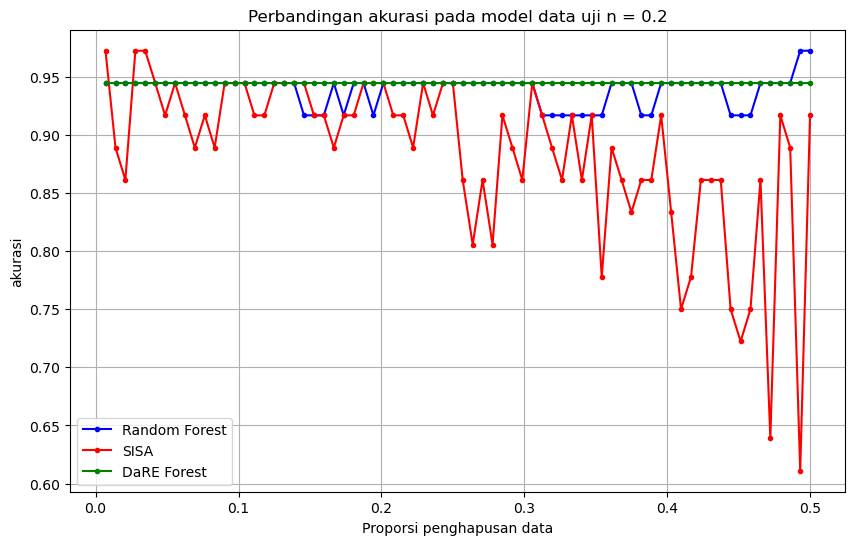

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy Base'], marker = ".",linestyle='-', color='blue', label='Random Forest')
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy SISA'], marker = ".",linestyle='-', color='red', label='SISA' )
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Accuracy DaRE'], marker = ".",linestyle='-', color='green', label='DaRE Forest')


plt.title("Perbandingan akurasi pada model data uji n = 0.2")
plt.xlabel("Proporsi penghapusan data")
plt.ylabel("akurasi")
plt.legend()
plt.grid(True)
plt.xticks(ticks=np.arange(0, 0.6, 0.1), labels=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5'])
plt.show()

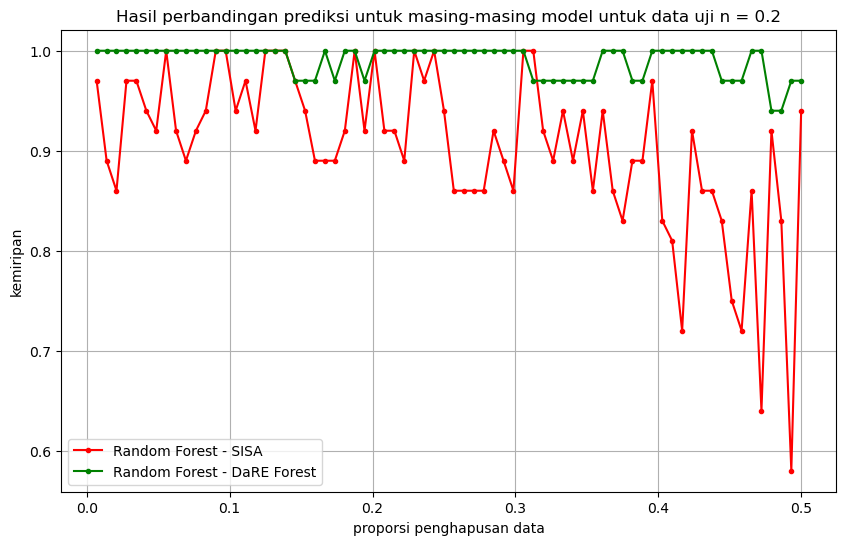

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_comparition['Proporsi penghapusan'], y_pred_comparition['Random Forest - SISA'], marker = ".",linestyle='-', color='red', label='Random Forest - SISA')
plt.plot(y_pred_comparition['Proporsi penghapusan'], y_pred_comparition['Random Forest - DaRE Forest'], marker = ".",linestyle='-', color='green', label='Random Forest - DaRE Forest')

plt.title("Hasil perbandingan prediksi untuk masing-masing model untuk data uji n = 0.2")
plt.xlabel("proporsi penghapusan data")
plt.ylabel("kemiripan")
plt.legend()
plt.grid(True)
plt.show()

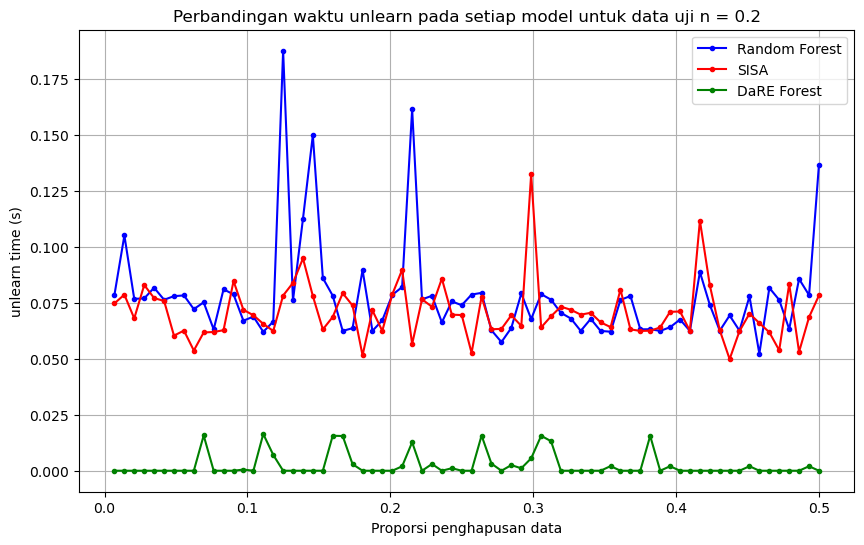

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Time Base'], marker = ".",linestyle='-', color='blue', label='Random Forest')
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Time SISA'], marker = ".",linestyle='-', color='red', label='SISA' )
plt.plot(comparition_model['Proporsi penghapusan'],comparition_model['Time DaRE'], marker = ".",linestyle='-', color='green', label='DaRE Forest')


plt.title("Perbandingan waktu unlearn pada setiap model untuk data uji n = 0.2")
plt.xlabel("Proporsi penghapusan data")
plt.ylabel("unlearn time (s)")
plt.legend()
plt.grid(True)
plt.xticks(ticks=np.arange(0, 0.6, 0.1), labels=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5'])
plt.show()

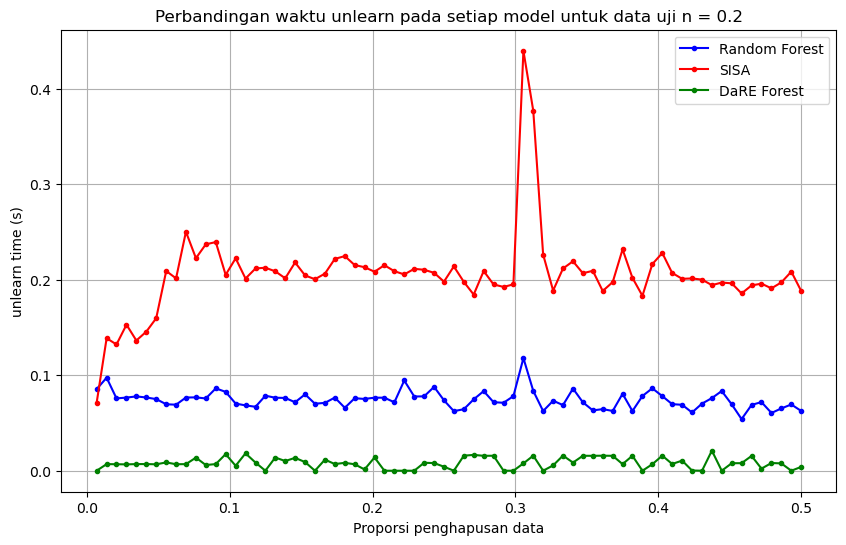

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(comparition_model_exp1['Proporsi penghapusan'],comparition_model_exp1['Time Base'], marker = ".",linestyle='-', color='blue', label='Random Forest')
plt.plot(comparition_model_exp1['Proporsi penghapusan'],comparition_model_exp1['Time SISA'], marker = ".",linestyle='-', color='red', label='SISA' )
plt.plot(comparition_model_exp1['Proporsi penghapusan'],comparition_model_exp1['Time DaRE'], marker = ".",linestyle='-', color='green', label='DaRE Forest')


plt.title("Perbandingan waktu unlearn pada setiap model untuk data uji n = 0.2")
plt.xlabel("Proporsi penghapusan data")
plt.ylabel("unlearn time (s)")
plt.legend()
plt.grid(True)
plt.xticks(ticks=np.arange(0, 0.6, 0.1), labels=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5'])
plt.show()